# Galaxy Zoo

Understanding how and why we are here is one of the fundamental questions for the human race. Part of the answer to this question lies in the origins of galaxies, such as our own Milky Way. Yet questions remain about how the Milky Way (or any of the other ~100 billion galaxies in our Universe) was formed and has evolved. Galaxies come in all shapes, sizes and colors: from beautiful spirals to huge ellipticals. Understanding the distribution, location and types of galaxies as a function of shape, size, and color are critical pieces for solving this puzzle.

![Image Credit: ESA/Hubble & NASA](https://storage.googleapis.com/kaggle-competitions/kaggle/3175/media/mainimage.jpg)

With each passing day telescopes around and above the Earth capture more and more images of distant galaxies. As better and bigger telescopes continue to collect these images, the datasets begin to explode in size. In order to better understand how the different shapes (or morphologies) of galaxies relate to the physics that create them, such images need to be sorted and classified. 

Hence the Galaxy Zoo Challenge!

## code


## Goal
The aim is to analyze the JPG images of galaxies to find automated metrics that reproduce the probability distributions derived from human classifications. For each galaxy, determine the probability that it belongs in a particular class. 

## Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt

## Unzip the training data  

In [2]:
!unzip -q /kaggle/input/galaxy-zoo-the-galaxy-challenge/training_solutions_rev1.zip

## Read and split the data and divide it in training and testing data

In [3]:
df = pd.read_csv('/kaggle/working/training_solutions_rev1.csv')

df_train, df_test = train_test_split(df[:30000], test_size=.2)
df_train.shape, df_test.shape

((24000, 38), (6000, 38))

#### Basic EDA

In [4]:
df_train.describe()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,320507.163542,0.430520,0.544595,0.024886,0.106593,0.438002,0.103231,0.334771,0.218036,0.219966,...,0.032339,0.093223,0.084466,0.040347,0.015513,0.095465,0.017722,0.007667,0.007217,0.074452
std,126414.138911,0.282627,0.295396,0.037522,0.212487,0.301768,0.178758,0.247632,0.286631,0.179074,...,0.097366,0.146182,0.140512,0.101148,0.053099,0.195558,0.067934,0.038384,0.038279,0.107558
min,100008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,209847.750000,0.176581,0.285225,0.000000,0.000000,0.170312,0.000000,0.124262,0.000000,0.073020,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,322018.500000,0.414518,0.561662,0.014710,0.000000,0.400073,0.000000,0.293283,0.096700,0.184173,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,429737.500000,0.674509,0.810503,0.033893,0.086090,0.694629,0.135361,0.518311,0.336458,0.338760,...,0.000000,0.150076,0.128465,0.030801,0.000000,0.100016,0.000000,0.000000,0.000000,0.130359
max,540188.000000,1.000000,1.000000,0.935147,1.000000,1.000000,1.000000,1.000000,1.000000,0.925311,...,0.874390,0.949733,0.877393,0.996952,0.843726,1.000000,0.975913,0.957000,0.938881,0.664057


In [5]:
print("Shape of the train set: ",df_train.shape)

print("Shape of the test set: ",df_test.shape)

Shape of the train set:  (24000, 38)
Shape of the test set:  (6000, 38)


#### Unzipping train and test images

In [6]:
!unzip -q /kaggle/input/galaxy-zoo-the-galaxy-challenge/images_training_rev1.zip
!unzip -q /kaggle/input/galaxy-zoo-the-galaxy-challenge/images_test_rev1.zip

#### EDA Images

In [8]:
trainPath = '/kaggle/working/images_training_rev1'
testPath = '/kaggle/working/images_test_rev1'

In [10]:
def plot_random_galaxy(path, sample = 5):
    random_image=random.sample(os.listdir(path),sample)
 
    plt.figure(figsize=(16,5))
    for i in range(sample):
        
        plt.subplot(1,sample,i+1)
        img=tf.io.read_file(os.path.join(path,random_image[i]))
        img=tf.io.decode_image(img)
        plt.imshow(img)
        plt.title(f'Class: {random_image[i]}\nShape: {img.shape}')
        plt.axis(False) 

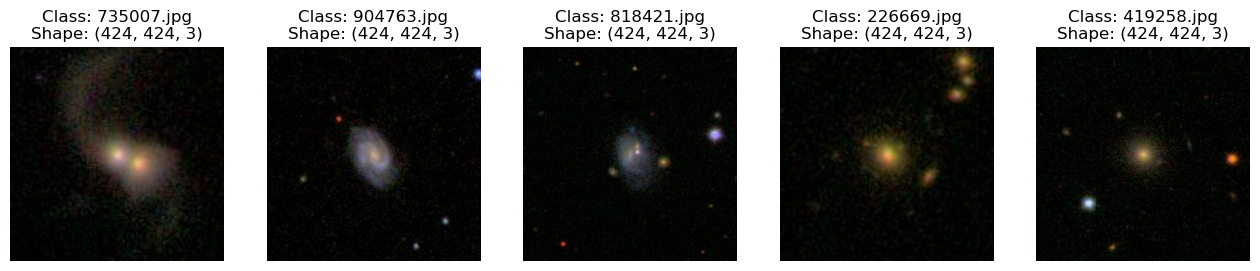

In [11]:
plot_random_galaxy(trainPath)

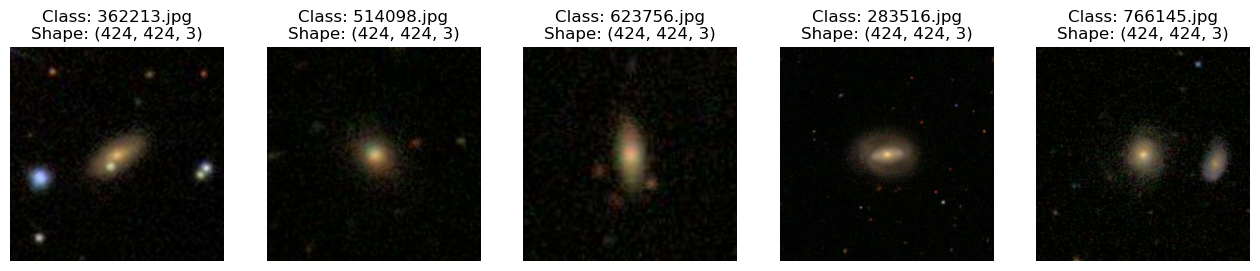

In [12]:
plot_random_galaxy(testPath)

**We can see a mix of elliptical and spiral galaxies in both train and test datasets.**

#### Read images in reference to the csv file, Resize and split them into train and test data(X,y) 

In [13]:

from skimage.transform import resize
from tqdm import tqdm # progress which the model
import matplotlib.pyplot as plt
%matplotlib inline
          

ORIG_SHAPE = (424,424)
CROP_SIZE = (256,256)
IMG_SHAPE = (64,64)

def get_image(path, x1,y1, shape, crop_size):
    x = plt.imread(path)
    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    x = resize(x, shape)
    x = x/255.
    return x
    
def get_all_images(dataframe, shape=IMG_SHAPE, crop_size=CROP_SIZE):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2
   
    sel = dataframe.values
    ids = sel[:,0].astype(int).astype(str)
    y_batch = sel[:,1:]
    x_batch = []
    for i in tqdm(ids):
        x = get_image('/kaggle/working/images_training_rev1/'+i+'.jpg', x1,y1, shape=shape, crop_size=crop_size)
        x_batch.append(x)
    x_batch = np.array(x_batch)
    return x_batch, y_batch
        
X_train, y_train = get_all_images(df_train)
X_test, y_test = get_all_images(df_test)

100%|██████████| 6000/6000 [00:58<00:00, 101.94it/s]


In [14]:
X_train.shape

(24000, 64, 64, 3)

In [15]:
df_train.values[0].shape

(38,)

#### Build a Deep learning Model using Mirrored Strategy 

In [80]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalMaxPooling2D
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

#to use two GPUs in parallel
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = Sequential()
    model.add(Conv2D(512, (3, 3), input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3)))
    model.add(Conv2D(256, (3, 3)))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3)))
    model.add(Conv2D(128, (3, 3)))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3)))
    model.add(Conv2D(128, (3, 3)))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(GlobalMaxPooling2D())


    model.add(Dropout(0.25))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(37))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy',root_mean_squared_error])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 512)       14336     
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 256)       1179904   
                                                                 
 activation_7 (Activation)   (None, 60, 60, 256)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 256)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 256)       590080    
                                                                 
 conv2d_9 (Conv2D)           (None, 26, 26, 128)       295040    
                                                      

#### begin training

In [17]:
batch_size = 128
with strategy.scope():
    model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test),use_multiprocessing=True)

Epoch 1/20
750/750 [==============================] - 78s 77ms/step - loss: 0.3239 - accuracy: 0.5496 - root_mean_squared_error: 0.1811 - val_loss: 0.2997 - val_accuracy: 0.5965 - val_root_mean_squared_error: 0.1631
Epoch 2/20
750/750 [==============================] - 54s 72ms/step - loss: 0.3035 - accuracy: 0.5987 - root_mean_squared_error: 0.1660 - val_loss: 0.2960 - val_accuracy: 0.5965 - val_root_mean_squared_error: 0.1599
Epoch 3/20
750/750 [==============================] - 54s 72ms/step - loss: 0.2976 - accuracy: 0.5971 - root_mean_squared_error: 0.1605 - val_loss: 0.2918 - val_accuracy: 0.5965 - val_root_mean_squared_error: 0.1555
Epoch 4/20
750/750 [==============================] - 53s 71ms/step - loss: 0.2934 - accuracy: 0.5979 - root_mean_squared_error: 0.1566 - val_loss: 0.2885 - val_accuracy: 0.5965 - val_root_mean_squared_error: 0.1524
Epoch 5/20
750/750 [==============================] - 58s 77ms/step - loss: 0.2901 - accuracy: 0.6032 - root_mean_squared_error: 0.1534 

#### After 20 epochs,

* **Loss:** 0.2476
* **Accuracy:** 0.7494
* **Root Mean Squared Error:** 0.1066
* **Validation loss:** 0.2443
* **Validation Accuracy:** 0.7567
* **Validation Root Mean Squared Error:** 0.1035

#### Generate predictions on test data

Choosing only 1000 images, as more will crash kaggle due to memory limits

In [18]:
import os
from tqdm import tqdm
batch_size = 1
def test_image_generator(ids, shape=IMG_SHAPE):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2
    x_batch = []
    for i in ids:
        x = get_image('/kaggle/working/images_test_rev1/'+i, x1, y1, shape=IMG_SHAPE, crop_size=CROP_SIZE)
        x_batch.append(x)
    x_batch = np.array(x_batch)
    return x_batch

val_files = os.listdir('/kaggle/working/images_test_rev1/')
val_files = val_files[:1000]
val_predictions = []
N_val = len(val_files)
for i in tqdm(np.arange(0, N_val, batch_size)):
    if i+batch_size > N_val:
        upper = N_val
    else:
        upper = i+batch_size
    X = test_image_generator(val_files[i:upper])
    y_pred = model.predict(X, verbose=0)
    val_predictions.append(y_pred)
val_predictions = np.array(val_predictions)
Y_pred = np.vstack(val_predictions)
ids = np.array([v.split('.')[0] for v in val_files]).reshape(len(val_files),1)
submission_df = pd.DataFrame(np.hstack((ids, Y_pred)), columns=df.columns)
submission_df = submission_df.sort_values(by=['GalaxyID'])
submission_df.to_csv('sample_submission.csv', index=False)

100%|██████████| 1000/1000 [03:34<00:00,  4.65it/s]


#### Check the predictions

In [19]:
submission_df[:10]

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
275,100171,0.38754484,0.5948171,0.016056666,0.36411625,0.24021931,0.05490796,0.19221665,0.08029295,0.16792655,...,0.08677787,0.033580244,0.026411954,0.02227825,0.004497596,0.03160721,0.0010759978,0.00062886043,0.0011284911,0.04174979
878,100617,0.099143684,0.8894906,0.0112736765,0.015863582,0.87199384,0.20442653,0.6738619,0.692636,0.20178254,...,0.0032784147,0.3448074,0.3213103,0.091361895,0.04251437,0.31434968,0.13121887,0.067678206,0.04853694,0.19170496
536,100687,0.28635567,0.6903253,0.0291381,0.07983111,0.6139662,0.18696429,0.42653024,0.2586641,0.34183064,...,0.010039357,0.080549955,0.098759644,0.083395146,0.032820676,0.12931395,0.008758911,0.0036171405,0.0058388454,0.08525186
944,103058,0.45610794,0.5134659,0.03853654,0.1492212,0.35766867,0.079634406,0.28101555,0.085572876,0.26907763,...,0.020330222,0.031123823,0.03253933,0.032469142,0.011300858,0.037428457,0.0013788963,0.00079095067,0.0021648842,0.042322323
426,104706,0.6233195,0.32072082,0.05841579,0.0064635295,0.3359324,0.039830294,0.29611906,0.12834376,0.2119361,...,0.0029358894,0.05803802,0.044368993,0.018397892,0.017450333,0.027626472,0.0066764853,0.00355771,0.006588411,0.0611778
297,104869,0.8085433,0.14483011,0.04869581,0.0017241882,0.1384724,0.006665066,0.12676693,0.017614873,0.10918225,...,0.00011213537,0.007672417,0.004860226,0.0021342125,0.0016939733,0.001867446,0.00021995045,0.0001183783,0.0011169061,0.009000745
581,105186,0.6425585,0.31502733,0.046797693,0.008097719,0.3009343,0.033682037,0.27079436,0.063002646,0.24341105,...,0.0003820764,0.032187678,0.021815503,0.010471117,0.0075040543,0.01377304,0.0015864575,0.00072605524,0.0036546648,0.034779336
94,106476,0.19157727,0.807185,0.0076366537,0.16281058,0.6356511,0.1893294,0.41200873,0.3810487,0.23698306,...,0.03502165,0.14680655,0.13145642,0.079427384,0.017186347,0.19763118,0.014452619,0.0059528775,0.0054194485,0.1261477
73,107030,0.12743822,0.86187845,0.009849383,0.023668878,0.8360493,0.19986367,0.6348099,0.6182693,0.22916213,...,0.004221405,0.3035095,0.26825103,0.079540886,0.03533818,0.27761793,0.08346337,0.039973807,0.030524183,0.18640357
968,107194,0.14865497,0.8241086,0.02814837,0.03161246,0.7989845,0.21107346,0.60561854,0.52490264,0.2961574,...,0.013512734,0.18332519,0.225082,0.13295503,0.055347465,0.23235555,0.053768657,0.024677696,0.020383725,0.15145339


In [ ]:
"""val_files = os.listdir('/kaggle/working/images_test_rev1/')

len(val_files)

sub_ten = submission_df[:10]

labels = sub_ten.columns

labels

len(labels[1:])

sub_ten['GalaxyID'] = sub_ten['GalaxyID'].astype('int')

sub_ten.loc[:, sub_ten.columns != 'GalaxyID']=sub_ten.loc[:, sub_ten.columns != 'GalaxyID'].astype('float')

subs = sub_ten.copy()

sub_labels = subs.loc[:, sub_ten.columns != 'GalaxyID'].idxmax(axis=1)"""

#### Make a dataframe with only GalaxyID and Predicted class

In [21]:
labels = submission_df.columns

In [22]:
labels[1:]

Index(['Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1',
       'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2', 'Class5.3',
       'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2', 'Class7.3',
       'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6',
       'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1',
       'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3',
       'Class11.4', 'Class11.5', 'Class11.6'],
      dtype='object')

In [50]:
class_names = [
    'Smooth', 'Featured or disc', 'Star or artifact',
    'Edge on', 'Not edge on',
    'Bar through center', 'No bar',
    'Spiral', 'No Spiral',
    'No bulge', 'Just noticeable bulge', 'Obvious bulge', 'Dominant bulge',
    'Odd Feature', 'No Odd Feature',
    'Completely round', 'In between', 'Cigar shaped',
    'Ring (Oddity)', 'Lens or arc (Oddity)', 'Disturbed (Oddity)', 'Irregular (Oddity)',
        'Other (Oddity)', 'Merger (Oddity)', 'Dust lane (Oddity)',
    'Rounded bulge', 'Boxy bulge', 'No bulge',
    'Tightly wound arms', 'Medium wound arms', 'Loose wound arms',
    '1 Spiral Arm', '2 Spiral Arms', '3 Spiral Arms', '4 Spiral Arms', 'More than four Spiral Arms', "Can't tell",
]

In [51]:
class_to_label = dict(zip(class_names, labels[1:]))

In [52]:
class_to_label

{'Smooth': 'Class1.1',
 'Featured or disc': 'Class1.2',
 'Star or artifact': 'Class1.3',
 'Edge on': 'Class2.1',
 'Not edge on': 'Class2.2',
 'Bar through center': 'Class3.1',
 'No bar': 'Class3.2',
 'Spiral': 'Class4.1',
 'No Spiral': 'Class4.2',
 'No bulge': 'Class9.3',
 'Just noticeable bulge': 'Class5.2',
 'Obvious bulge': 'Class5.3',
 'Dominant bulge': 'Class5.4',
 'Odd Feature': 'Class6.1',
 'No Odd Feature': 'Class6.2',
 'Completely round': 'Class7.1',
 'In between': 'Class7.2',
 'Cigar shaped': 'Class7.3',
 'Ring (Oddity)': 'Class8.1',
 'Lens or arc (Oddity)': 'Class8.2',
 'Disturbed (Oddity)': 'Class8.3',
 'Irregular (Oddity)': 'Class8.4',
 'Other (Oddity)': 'Class8.5',
 'Merger (Oddity)': 'Class8.6',
 'Dust lane (Oddity)': 'Class8.7',
 'Rounded bulge': 'Class9.1',
 'Boxy bulge': 'Class9.2',
 'Tightly wound arms': 'Class10.1',
 'Medium wound arms': 'Class10.2',
 'Loose wound arms': 'Class10.3',
 '1 Spiral Arm': 'Class11.1',
 '2 Spiral Arms': 'Class11.2',
 '3 Spiral Arms': 'Cla

In [53]:
pairs = list(zip(labels[1:],class_to_label ))

labels_dict = dict(pairs)

In [54]:
labels_dict

{'Class1.1': 'Smooth',
 'Class1.2': 'Featured or disc',
 'Class1.3': 'Star or artifact',
 'Class2.1': 'Edge on',
 'Class2.2': 'Not edge on',
 'Class3.1': 'Bar through center',
 'Class3.2': 'No bar',
 'Class4.1': 'Spiral',
 'Class4.2': 'No Spiral',
 'Class5.1': 'No bulge',
 'Class5.2': 'Just noticeable bulge',
 'Class5.3': 'Obvious bulge',
 'Class5.4': 'Dominant bulge',
 'Class6.1': 'Odd Feature',
 'Class6.2': 'No Odd Feature',
 'Class7.1': 'Completely round',
 'Class7.2': 'In between',
 'Class7.3': 'Cigar shaped',
 'Class8.1': 'Ring (Oddity)',
 'Class8.2': 'Lens or arc (Oddity)',
 'Class8.3': 'Disturbed (Oddity)',
 'Class8.4': 'Irregular (Oddity)',
 'Class8.5': 'Other (Oddity)',
 'Class8.6': 'Merger (Oddity)',
 'Class8.7': 'Dust lane (Oddity)',
 'Class9.1': 'Rounded bulge',
 'Class9.2': 'Boxy bulge',
 'Class9.3': 'Tightly wound arms',
 'Class10.1': 'Medium wound arms',
 'Class10.2': 'Loose wound arms',
 'Class10.3': '1 Spiral Arm',
 'Class11.1': '2 Spiral Arms',
 'Class11.2': '3 Spiral

In [55]:
sub_df = submission_df.copy()

sub_df['GalaxyID'] = sub_df['GalaxyID'].astype('int')
sub_df.loc[:, sub_df.columns != 'GalaxyID']=sub_df.loc[:, sub_df.columns != 'GalaxyID'].astype('float')
sub_labels = sub_df.loc[:, sub_df.columns != 'GalaxyID'].idxmax(axis=1)

In [56]:
sub_labels.describe()

count         1000
unique           5
top       Class6.2
freq           644
dtype: object

In [57]:
labels_dict

{'Class1.1': 'Smooth',
 'Class1.2': 'Featured or disc',
 'Class1.3': 'Star or artifact',
 'Class2.1': 'Edge on',
 'Class2.2': 'Not edge on',
 'Class3.1': 'Bar through center',
 'Class3.2': 'No bar',
 'Class4.1': 'Spiral',
 'Class4.2': 'No Spiral',
 'Class5.1': 'No bulge',
 'Class5.2': 'Just noticeable bulge',
 'Class5.3': 'Obvious bulge',
 'Class5.4': 'Dominant bulge',
 'Class6.1': 'Odd Feature',
 'Class6.2': 'No Odd Feature',
 'Class7.1': 'Completely round',
 'Class7.2': 'In between',
 'Class7.3': 'Cigar shaped',
 'Class8.1': 'Ring (Oddity)',
 'Class8.2': 'Lens or arc (Oddity)',
 'Class8.3': 'Disturbed (Oddity)',
 'Class8.4': 'Irregular (Oddity)',
 'Class8.5': 'Other (Oddity)',
 'Class8.6': 'Merger (Oddity)',
 'Class8.7': 'Dust lane (Oddity)',
 'Class9.1': 'Rounded bulge',
 'Class9.2': 'Boxy bulge',
 'Class9.3': 'Tightly wound arms',
 'Class10.1': 'Medium wound arms',
 'Class10.2': 'Loose wound arms',
 'Class10.3': '1 Spiral Arm',
 'Class11.1': '2 Spiral Arms',
 'Class11.2': '3 Spiral

In [58]:
pred_class = [labels_dict[label] for label in sub_labels]

In [59]:
sub_df['Pred_class'] = pred_class

In [60]:
sub_df

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6,Pred_class
275,100171,0.387545,0.594817,0.016057,0.364116,0.240219,0.054908,0.192217,0.080293,0.167927,...,0.033580,0.026412,0.022278,0.004498,0.031607,0.001076,0.000629,0.001128,0.041750,No Odd Feature
878,100617,0.099144,0.889491,0.011274,0.015864,0.871994,0.204427,0.673862,0.692636,0.201783,...,0.344807,0.321310,0.091362,0.042514,0.314350,0.131219,0.067678,0.048537,0.191705,Featured or disc
536,100687,0.286356,0.690325,0.029138,0.079831,0.613966,0.186964,0.426530,0.258664,0.341831,...,0.080550,0.098760,0.083395,0.032821,0.129314,0.008759,0.003617,0.005839,0.085252,Featured or disc
944,103058,0.456108,0.513466,0.038537,0.149221,0.357669,0.079634,0.281016,0.085573,0.269078,...,0.031124,0.032539,0.032469,0.011301,0.037428,0.001379,0.000791,0.002165,0.042322,No Odd Feature
426,104706,0.623320,0.320721,0.058416,0.006464,0.335932,0.039830,0.296119,0.128344,0.211936,...,0.058038,0.044369,0.018398,0.017450,0.027626,0.006676,0.003558,0.006588,0.061178,No Odd Feature
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,998526,0.354318,0.632346,0.012882,0.368206,0.249760,0.043637,0.218908,0.107281,0.151275,...,0.049863,0.032845,0.022644,0.004454,0.036693,0.002179,0.001067,0.001568,0.060303,No Odd Feature
433,998634,0.504773,0.480951,0.014338,0.029759,0.445377,0.076466,0.370550,0.154814,0.288109,...,0.087224,0.048665,0.017411,0.009576,0.048270,0.003521,0.001694,0.003515,0.087099,No Odd Feature
794,998651,0.273507,0.699223,0.026499,0.010765,0.697675,0.115668,0.571282,0.427788,0.279863,...,0.213815,0.164708,0.048042,0.039783,0.138316,0.047829,0.023703,0.020412,0.167296,Featured or disc
124,999339,0.797108,0.159719,0.039297,0.001613,0.161031,0.007062,0.152367,0.022097,0.127563,...,0.009714,0.005878,0.002219,0.001814,0.002384,0.000281,0.000146,0.001325,0.011688,No Odd Feature


In [61]:
predictions = sub_df.copy()

In [62]:
predictions = predictions.loc[:,['GalaxyID', 'Pred_class']]

In [63]:
predictions

,GalaxyID,Pred_class
275,100171,No Odd Feature
878,100617,Featured or disc
536,100687,Featured or disc
944,103058,No Odd Feature
426,104706,No Odd Feature
...,...,...
151,998526,No Odd Feature
433,998634,No Odd Feature
794,998651,Featured or disc
124,999339,No Odd Feature


In [85]:
model.save('classification_model.h5')



1/1 [==============================] - 0s 162ms/step
Predicted class: No bulge


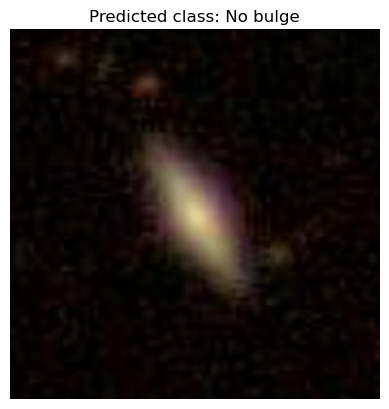

In [92]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np


sample_image_path = '/kaggle/working/images_test_rev1/100171.jpg'

sample_image = load_img(sample_image_path, target_size=(224, 224))
sample_image_array = img_to_array(sample_image)
sample_image_array = np.expand_dims(sample_image_array, axis=0)
sample_image_array /= 255.0 


pred = model.predict(sample_image_array)
predicted_class_index = np.argmax(pred)

# Convert predicted class index to class name using class_names list
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted class: {predicted_class_name}")
plt.imshow(sample_image)
plt.title(f"Predicted class: {predicted_class_name}")
plt.axis('off') 
plt.show()

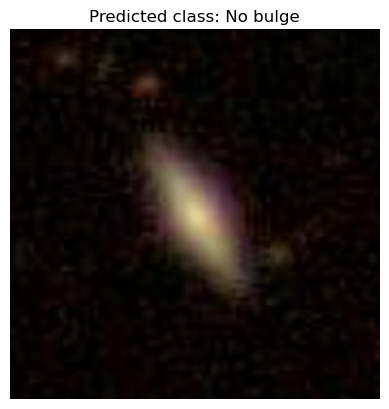

In [91]:
plt.imshow(sample_image)
plt.title(f"Predicted class: {predicted_class_name}")
plt.axis('off') 
plt.show()

In [69]:
import matplotlib.pyplot as plt

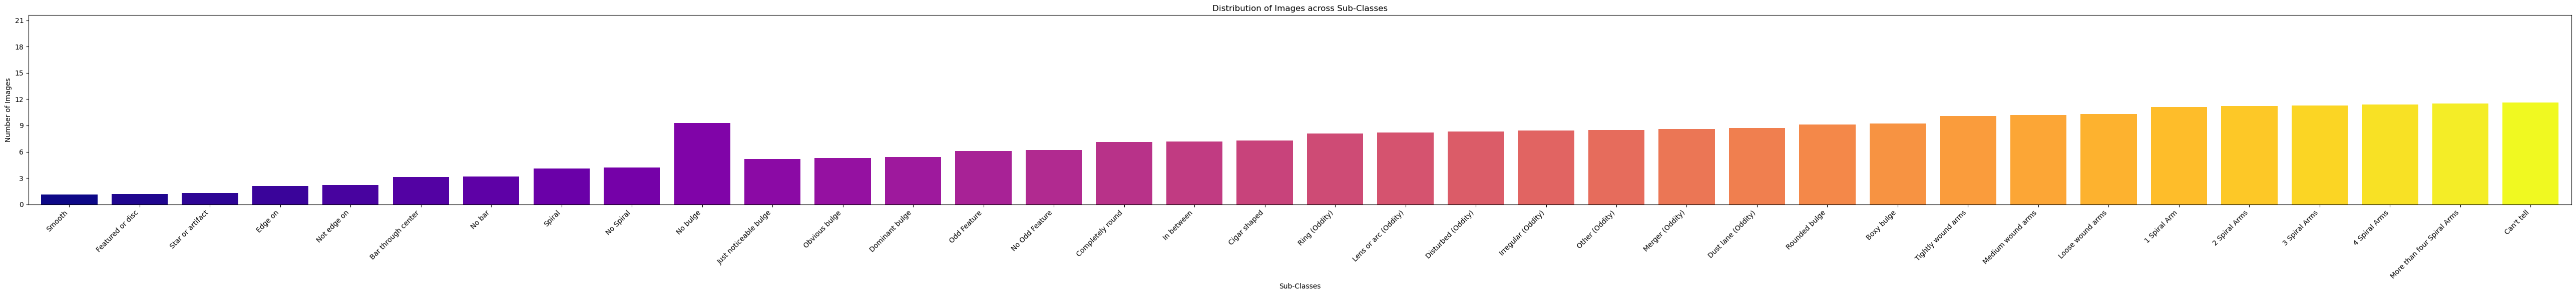

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Assuming you have the labels, class_to_label dictionary defined somewhere
import re

# Assuming you have the labels, class_to_label dictionary, and colors defined somewhere
labels = list(class_to_label.keys())
class_counts = [float(re.search(r'\d+\.\d+', count).group()) for count in class_to_label.values()]  # Extract numeric values
colors = ['blue', 'green', 'red', 'purple', 'orange', 'pink', 'cyan', 'brown', 'gray', 'teal']  # Define your colors

  # Convert to integers

# Create a custom color gradient
colors = plt.cm.get_cmap('plasma', len(labels))  # Choose a colormap and set the number of colors

# Plot the bar chart
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
bars = plt.bar(labels, class_counts, color=colors(np.linspace(0, 1, len(labels))))  # Apply colors

plt.xlabel('Sub-Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Images across Sub-Classes')
plt.xticks(rotation=45, ha='right')

# Adjust spacing between labels
plt.gca().margins(x=0.005)
plt.gcf().canvas.draw()
tl = plt.gca().get_xticklabels()
maxsize = max([t.get_window_extent().width for t in tl])
m = 0.2  # inch margin
s = maxsize / plt.gcf().dpi * len(labels) + 2 * m
margin = m / plt.gcf().get_size_inches()[0]
plt.gcf().subplots_adjust(left=margin, right=1. - margin)
plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])

# Adjust y-axis limits and ticks
plt.gca().set_ylim(0, max(class_counts) + 10)  # Adjust the upper limit as needed
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()
